# Analysis

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import h5py
from resnet import ResidualBlock, ResNet
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import norm
from tensorflow.compat.v1.train import summary_iterator
from collections import defaultdict

cuda:0
dataset loaded
train test split finished


## Load data and create model

In [2]:
with h5py.File('data/uci_ml_hackathon_fire_dataset_2012-05-09_2013-01-01_30k_train_v2.hdf5', 'r') as f:
    train_data = {}
    for k in list(f):
        train_data[k] = f[k][:]

In [3]:
with h5py.File('data/uci_ml_hackathon_fire_dataset_2013-01-01_2014-01-01_5k_test_v2.hdf5', 'r') as f:
    test_data = {}
    for k in list(f):
        test_data[k] = f[k][:]

In [4]:
model0 = ResNet(ResidualBlock, [2, 2, 2])
model12 = ResNet(ResidualBlock, [2, 2, 2])

## Training loss evaluation

In [15]:
resnet0_values = defaultdict(list)
for e in summary_iterator('log/resnet_0/events.out.tfevents.1590213759.LI-Desktop.12904.0'):
    for v in e.summary.value:
        resnet0_values[v.tag].append(v.simple_value)

In [16]:
resnet12_values = defaultdict(list)
for e in summary_iterator('log/resnet_12/events.out.tfevents.1590219309.LI-Desktop.28296.0'):
    for v in e.summary.value:
        resnet12_values[v.tag].append(v.simple_value)

***Note***: IoU compute during the training set the threshold as 0. That says for any pixel predicted with value greater than 0 is considered as the positive fireplace.

### +12 evaluation

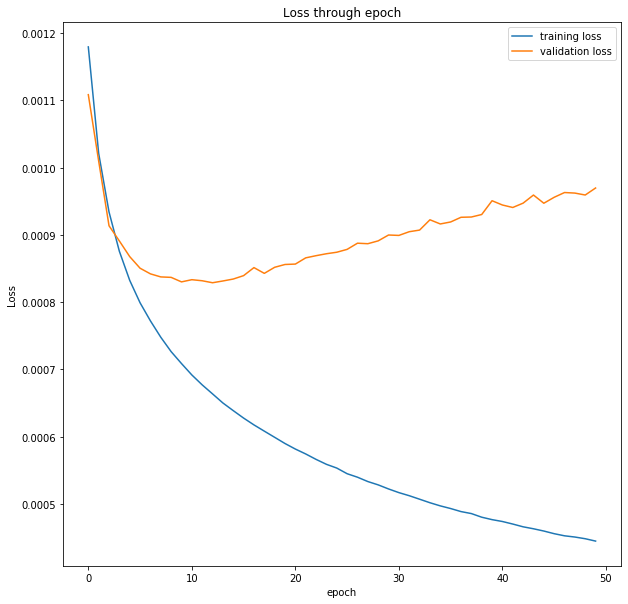

In [85]:
fig = plt.figure(figsize=(10,10))
plt.plot(range(50), np.array(resnet0_values['Train/Loss']), label='training loss')
plt.plot(range(50), np.array(resnet0_values['Valid/Loss']), label='validation loss')
plt.title('Loss through epoch')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('fig/12loss')
plt.show()

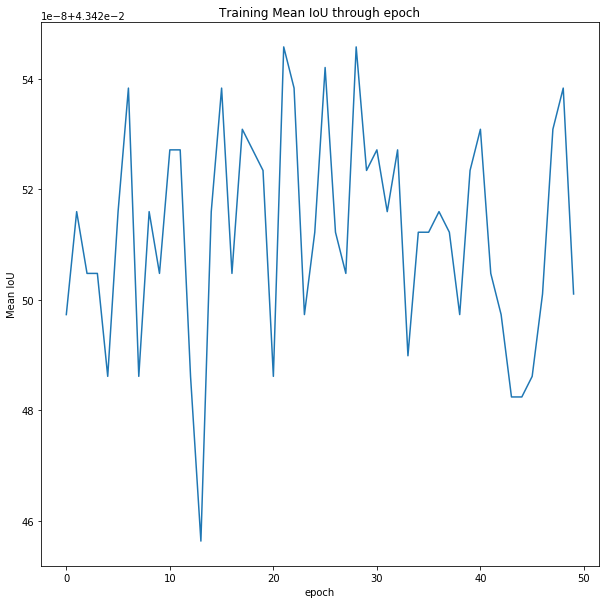

In [87]:
plt.figure(figsize=(10,10))
plt.plot(range(50), np.array(resnet0_values['Train/Mean IoU']))
plt.title('Training Mean IoU through epoch')
plt.xlabel('epoch')
plt.ylabel('Mean IoU')
# plt.savefig('fig/12trainiou')
plt.show()

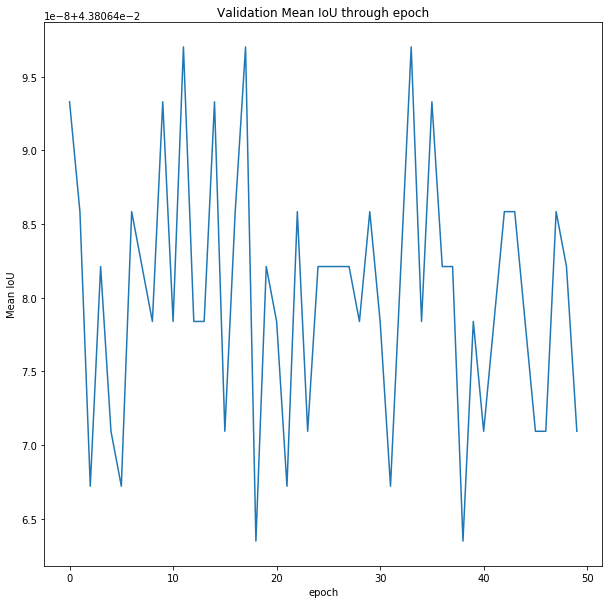

In [88]:
plt.figure(figsize=(10,10))
plt.plot(range(50), np.array(resnet0_values['Valid/Mean IoU']))
plt.title('Validation Mean IoU through epoch')
plt.xlabel('epoch')
plt.ylabel('Mean IoU')
# plt.savefig('fig/12validiou')
plt.show()

### +24 evaluation

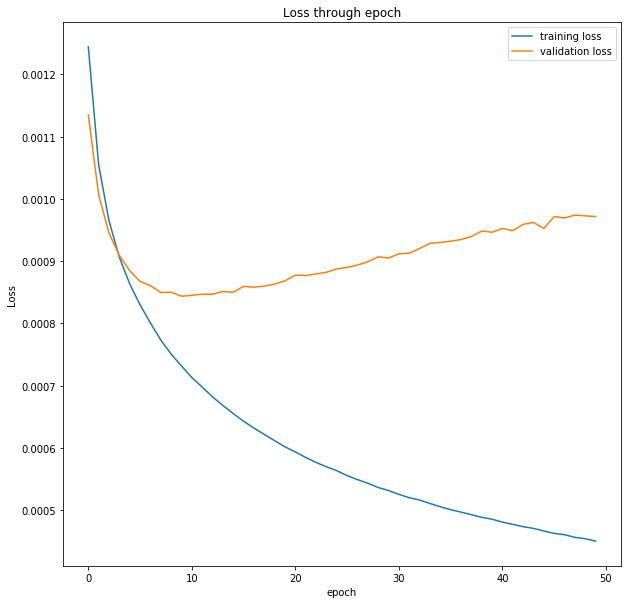

In [89]:
fig = plt.figure(figsize=(10,10))
plt.plot(range(50), np.array(resnet12_values['Train/Loss']), label='training loss')
plt.plot(range(50), np.array(resnet12_values['Valid/Loss']), label='validation loss')
plt.title('Loss through epoch')
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('fig/24loss')
plt.show()

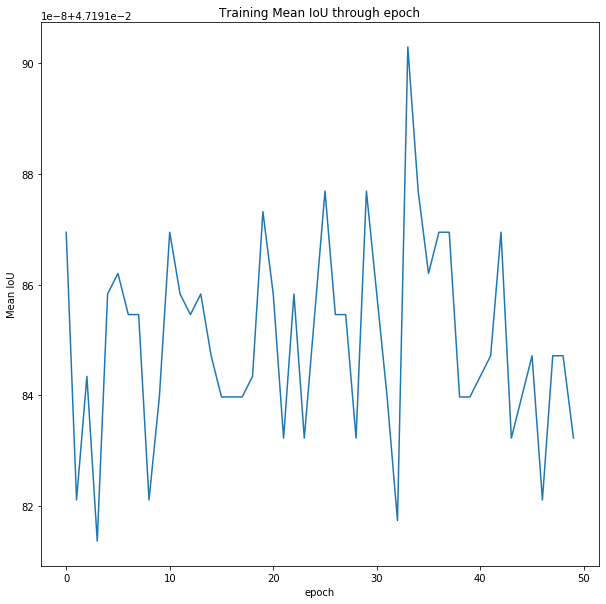

In [90]:
plt.figure(figsize=(10,10))
plt.plot(range(50), np.array(resnet12_values['Train/Mean IoU']))
plt.title('Training Mean IoU through epoch')
plt.xlabel('epoch')
plt.ylabel('Mean IoU')
# plt.savefig('fig/24trainiou')
plt.show()

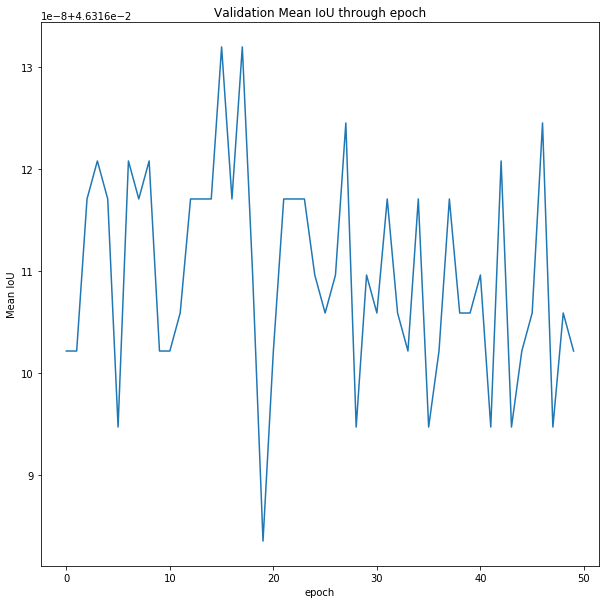

In [91]:
plt.figure(figsize=(10,10))
plt.plot(range(50), np.array(resnet12_values['Valid/Mean IoU']))
plt.title('Validation Mean IoU through epoch')
plt.xlabel('epoch')
plt.ylabel('Mean IoU')
# plt.savefig('fig/24validiou')
plt.show()

## Load desired model

In [5]:
model0.load_state_dict(torch.load('model/resnet_0/best_valid_loss')['model_state_dict'])
model12.load_state_dict(torch.load('model/resnet_12/best_valid_loss')['model_state_dict'])

<All keys matched successfully>

In [6]:
model0.eval()
model12.eval()
print()

## Evaluation on test datasets

### MSE

In [7]:
ypred0 = model0(torch.Tensor(test_data['observed'])).detach()

In [8]:
ypred12 = model12(torch.Tensor(test_data['observed'])).detach()

In [9]:
ytrue0 = test_data['target'][:,0,...].reshape((-1,900))
ytrue12 = test_data['target'][:,1,...].reshape((-1,900))

In [48]:
print('MSE for +12 is:', MSE(ytrue0, ypred0))

MSE for +12 is: 0.043933723


In [49]:
print('MSE for +24 is:', MSE(ytrue12, ypred12))

MSE for +24 is: 0.042786136


`visualization when doing presentation`

### IoU for different threshold

In [10]:
def IoU(predict, target, smooth=1e-6, thres=0):
    intersection = ((predict > thres) & (target > 0)).sum(1)
    union = ((predict > thres) | (target > 0)).sum(1)
    iou = (intersection + smooth) / (union + smooth)
    return iou.numpy()

In [11]:
thres = np.linspace(0,1,101)
mean_iou0 = np.array([np.mean(IoU(ypred0, ytrue0, thres=t)) for t in thres])
mean_iou12 = np.array([np.mean(IoU(ypred12, ytrue12, thres=t)) for t in thres])

In [12]:
std_iou0 = np.array([np.std(IoU(ypred0, ytrue0, thres=t)) for t in thres])
std_iou12 = np.array([np.std(IoU(ypred12, ytrue12, thres=t)) for t in thres])

In [80]:
x = np.linspace(norm.ppf(0.01,loc=mean_iou0[0], scale=std_iou0[0]),
                norm.ppf(0.99,loc=mean_iou0[0], scale=std_iou0[0]),100)
norm.pdf(x, loc=mean_iou0[0], scale=std_iou0[0])

array([0.4473674 , 0.49850171, 0.55425516, 0.61488458, 0.6806412 ,
       0.75176764, 0.82849482, 0.9110385 , 0.99959583, 1.0943416 ,
       1.19542449, 1.30296323, 1.41704271, 1.53771018, 1.66497151,
       1.79878764, 1.93907117, 2.08568335, 2.23843129, 2.39706567,
       2.56127885, 2.7307036 , 2.90491235, 3.08341706, 3.26566987,
       3.45106433, 3.63893753, 3.82857285, 4.01920352, 4.210017  ,
       4.40016002, 4.58874433, 4.77485316, 4.95754823, 5.13587736,
       5.30888247, 5.47560795, 5.63510936, 5.78646222, 5.92877083,
       6.0611771 , 6.18286912, 6.2930894 , 6.39114277, 6.4764036 ,
       6.54832251, 6.60643224, 6.65035269, 6.67979509, 6.69456513,
       6.69456513, 6.67979509, 6.65035269, 6.60643224, 6.54832251,
       6.4764036 , 6.39114277, 6.2930894 , 6.18286912, 6.0611771 ,
       5.92877083, 5.78646222, 5.63510936, 5.47560795, 5.30888247,
       5.13587736, 4.95754823, 4.77485316, 4.58874433, 4.40016002,
       4.210017  , 4.01920352, 3.82857285, 3.63893753, 3.45106

In [70]:
np.where(thres==0.5)

(array([50], dtype=int64),)

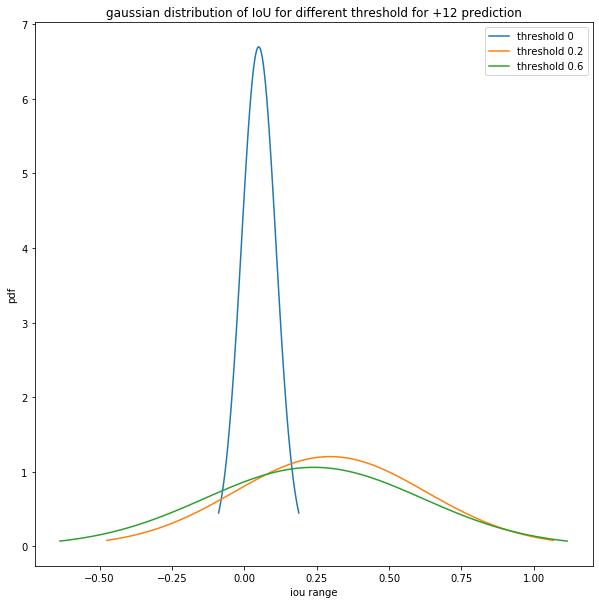

In [40]:
plt.figure(figsize=(10,10))
x = np.linspace(norm.ppf(0.01,loc=mean_iou0[0], scale=std_iou0[0]),
                norm.ppf(0.99,loc=mean_iou0[0], scale=std_iou0[0]),100)
plt.plot(x, norm.pdf(x, loc=mean_iou0[0], scale=std_iou0[0]), label='threshold 0')
x = np.linspace(norm.ppf(0.01,loc=mean_iou0[20], scale=std_iou0[20]),
                norm.ppf(0.99,loc=mean_iou0[20], scale=std_iou0[20]),100)
plt.plot(x, norm.pdf(x, loc=mean_iou0[20], scale=std_iou0[20]), label='threshold 0.2')
x = np.linspace(norm.ppf(0.01,loc=mean_iou0[60], scale=std_iou0[60]),
                norm.ppf(0.99,loc=mean_iou0[60], scale=std_iou0[60]),100)
plt.plot(x, norm.pdf(x, loc=mean_iou0[60], scale=std_iou0[60]), label='threshold 0.6')
plt.legend()
plt.xlabel('iou range')
plt.ylabel('pdf')
plt.title('gaussian distribution of IoU for different threshold for +12 prediction')
# plt.savefig('fig/12gaussainiou')
plt.show()

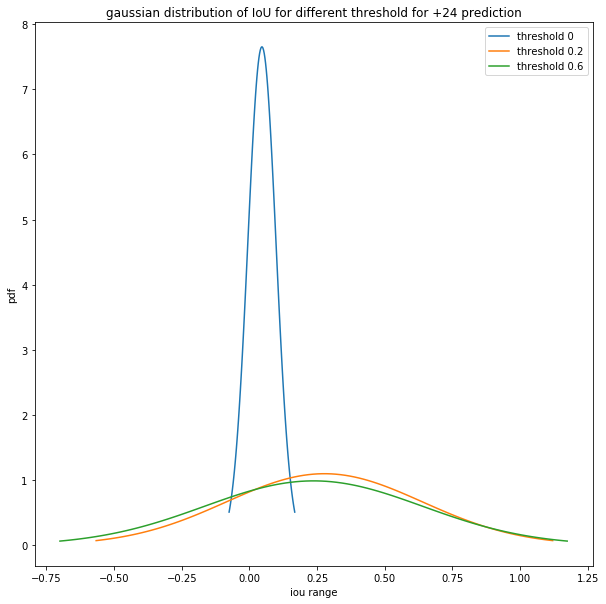

In [39]:
plt.figure(figsize=(10,10))
x = np.linspace(norm.ppf(0.01,loc=mean_iou12[0], scale=std_iou12[0]),
                norm.ppf(0.99,loc=mean_iou12[0], scale=std_iou12[0]),100)
plt.plot(x, norm.pdf(x, loc=mean_iou12[0], scale=std_iou12[0]), label='threshold 0')
x = np.linspace(norm.ppf(0.01,loc=mean_iou12[20], scale=std_iou12[20]),
                norm.ppf(0.99,loc=mean_iou12[20], scale=std_iou12[20]),100)
plt.plot(x, norm.pdf(x, loc=mean_iou12[20], scale=std_iou12[20]), label='threshold 0.2')
x = np.linspace(norm.ppf(0.01,loc=mean_iou12[60], scale=std_iou12[60]),
                norm.ppf(0.99,loc=mean_iou12[60], scale=std_iou12[60]),100)
plt.plot(x, norm.pdf(x, loc=mean_iou12[60], scale=std_iou12[60]), label='threshold 0.6')
plt.legend()
plt.xlabel('iou range')
plt.ylabel('pdf')
plt.title('gaussian distribution of IoU for different threshold for +24 prediction')
# plt.savefig('fig/24gaussainiou')
plt.show()

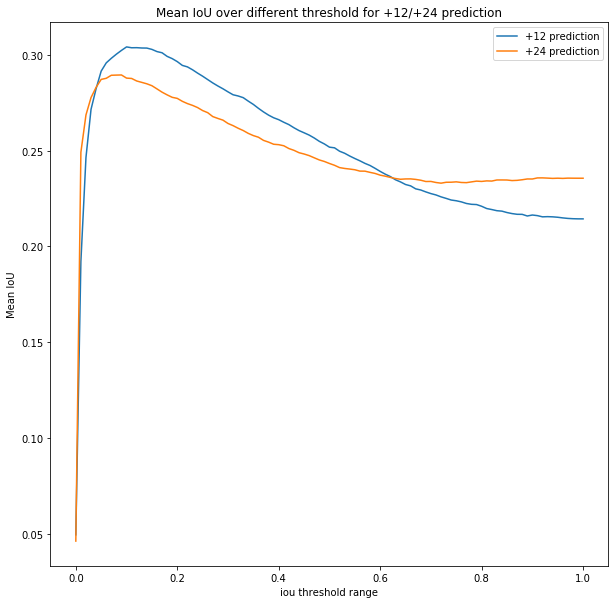

In [94]:
plt.figure(figsize=(10,10))
plt.plot(thres, mean_iou0, label='+12 prediction')
plt.plot(thres, mean_iou12, label='+24 prediction')
plt.legend()
plt.xlabel('iou threshold range')
plt.ylabel('Mean IoU')
plt.title('Mean IoU over different threshold for +12/+24 prediction')
# plt.savefig('fig/testmeaniou')
plt.show()

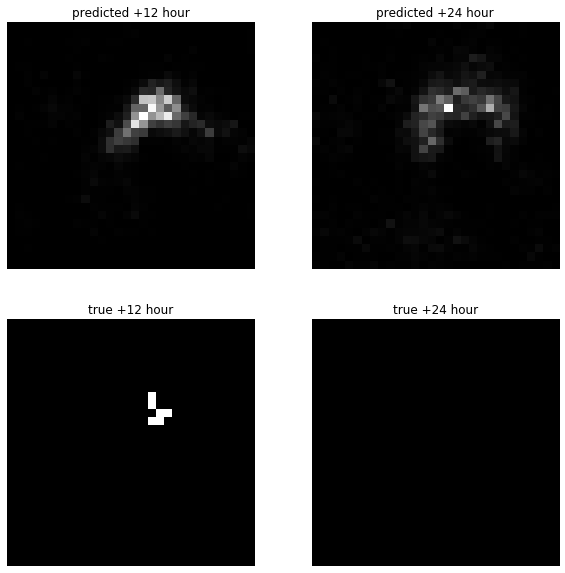

In [24]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
# ind = np.random.choice(range(test_data['target'].shape[0]))
ax[0,0].imshow(ypred0[ind].reshape((30,30)), cmap='gray')
ax[0,0].set_title('predicted +12 hour')
ax[0,0].axis('off')
ax[0,1].imshow(ypred12[ind].reshape((30,30)), cmap='gray')
ax[0,1].set_title('predicted +24 hour')
ax[0,1].axis('off')
ax[1,0].imshow(ytrue0[ind].reshape((30,30)), cmap='gray')
ax[1,0].set_title('true +12 hour')
ax[1,0].axis('off')
ax[1,1].imshow(ytrue12[ind].reshape((30,30)), cmap='gray')
ax[1,1].set_title('true +24 hour')
ax[1,1].axis('off')
plt.show()

In [26]:
large_fire_inds = np.where(
    (np.sum(test_data['observed'][:,0],axis=(1,2)) > 50) & 
    (np.sum(test_data['observed'][:,1],axis=(1,2)) > 50) & 
    (np.sum(test_data['observed'][:,2],axis=(1,2)) > 50) & 
    (np.sum(test_data['observed'][:,3],axis=(1,2)) > 50) & 
    (np.sum(test_data['observed'][:,4],axis=(1,2)) > 50) & 
    (np.sum(test_data['target'][:,0],axis=(1,2)) > 50) 
)[0]

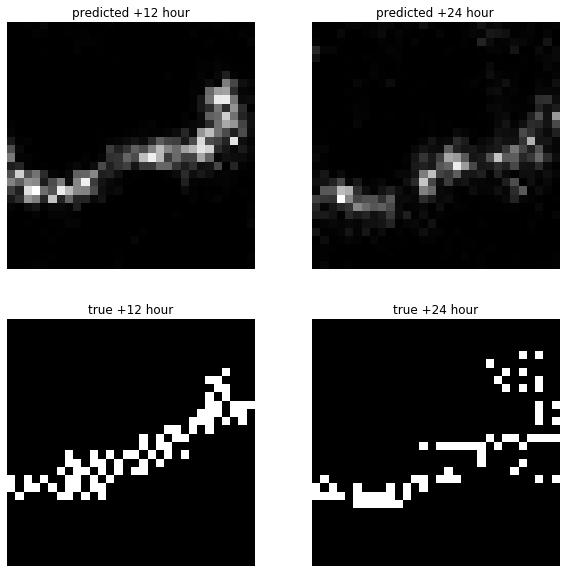

In [37]:
fig, ax = plt.subplots(2,2, figsize=(10,10))
ind = np.random.choice(large_fire_inds)
ax[0,0].imshow(ypred0[ind].reshape((30,30)), cmap='gray')
ax[0,0].set_title('predicted +12 hour')
ax[0,0].axis('off')
ax[0,1].imshow(ypred12[ind].reshape((30,30)), cmap='gray')
ax[0,1].set_title('predicted +24 hour')
ax[0,1].axis('off')
ax[1,0].imshow(ytrue0[ind].reshape((30,30)), cmap='gray')
ax[1,0].set_title('true +12 hour')
ax[1,0].axis('off')
ax[1,1].imshow(ytrue12[ind].reshape((30,30)), cmap='gray')
ax[1,1].set_title('true +24 hour')
ax[1,1].axis('off')
plt.show()